## Import Library

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Libraries for EDA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

# Libraries for machine learning
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, roc_curve, auc

## Data Preprocessing

### Load Dataset

In [ ]:
# reading the data
data= pd.read_csv("/content/healthcare-dataset-stroke-data.csv")

original_shape= data.shape
print(f"data shape: {original_shape}\n")

data.head()

data shape: (5110, 12)



,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Data Overview

In [ ]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
# what data types we have
print(data.dtypes)

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


### Data Cleaning

#### Check and Handling Missing Value

In [ ]:
# Check for missing values
data.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


In [ ]:
# Fill missing BMI values with the mean BMI
data['bmi'].fillna(data['bmi'].mean(), inplace=True)

In [ ]:
data.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0


#### Check and Handling Outlier

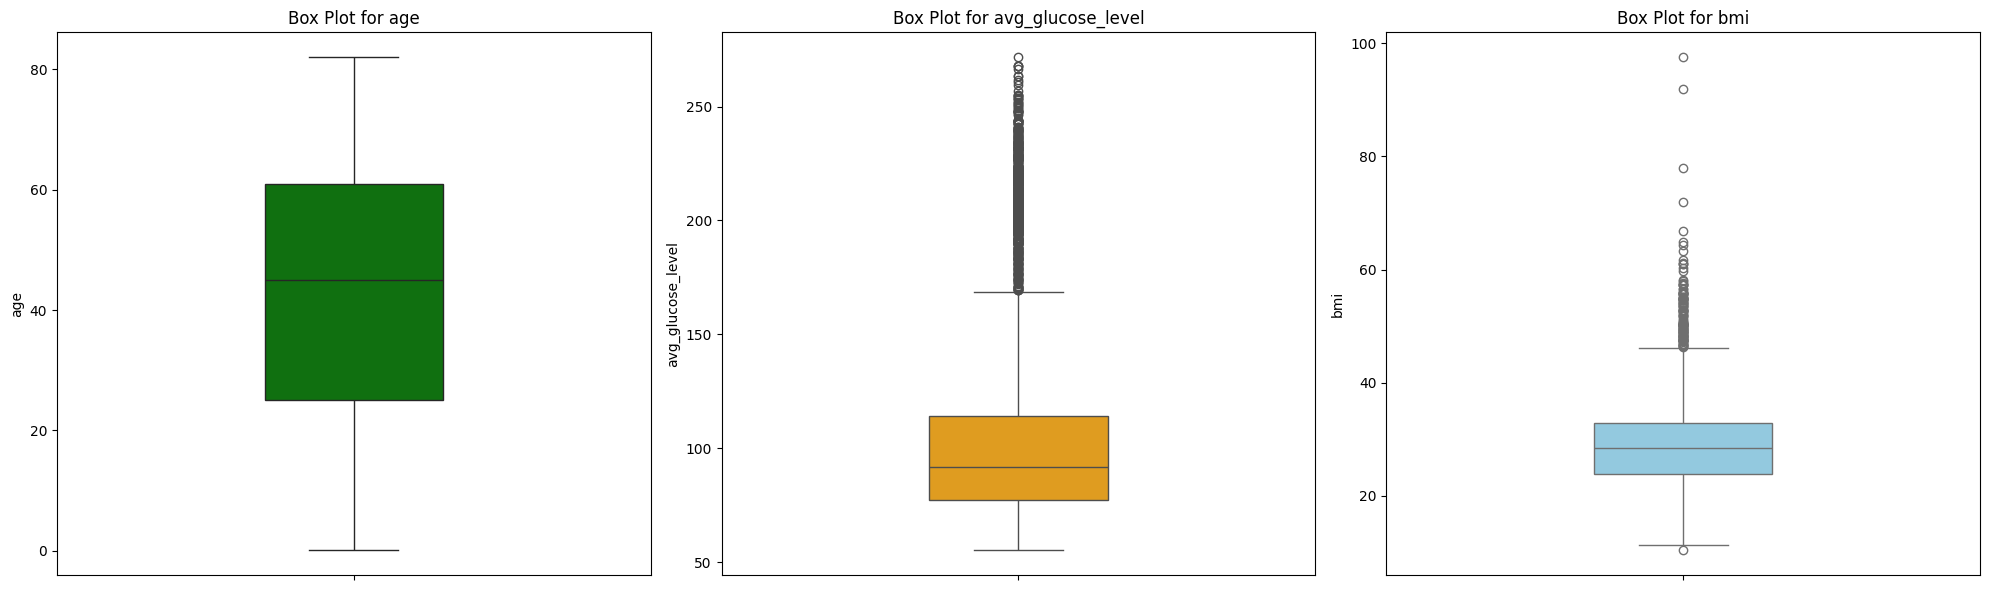

In [ ]:
# Box Plots for numerical features to visualize if there are outliers

# Select numerical features
numerical_columns = data.select_dtypes(exclude=['object', 'int']).columns

# Create a figure with 13 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

axes = axes.flatten()

# Define Colors
colors = ['green', 'orange', 'skyblue']
# Iterate over each numerical column and plot a Box Plot
for i, column in enumerate(numerical_columns):
    sns.boxplot(data[column], ax=axes[i], color=colors[i], width=0.3)
    axes[i].set_title(f"Box Plot for {column}")
    axes[i].set_ylabel(f"{column}")

plt.tight_layout()
plt.show()

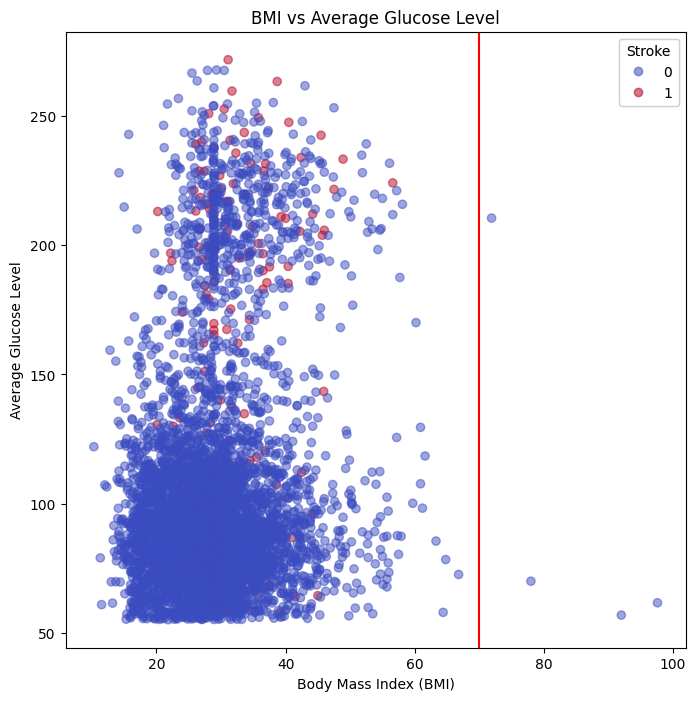

In [ ]:
# Three Option:
    # 1. Graphic method with a Scatter Plot
    # 2. The interquartile range (IQR) method
    # 3. The percentile method with 0.001 and 0.999

# 1. Scatter plot using the two features with outliers: bmi and avg_glucose_level# Create a scatter plot with points colored according to the stroke feature
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(data['bmi'], data['avg_glucose_level'], c=data['stroke'], cmap='coolwarm', alpha=0.5)
ax.axvline(70, color='red')
legend1 = ax.legend(*scatter.legend_elements(), title='Stroke')
ax.add_artist(legend1)

ax.set_title('BMI vs Average Glucose Level')
ax.set_xlabel('Body Mass Index (BMI)')
ax.set_ylabel('Average Glucose Level')

plt.show()

In [ ]:
# 2. The interquartile range (IQR) method for bmi feature

feature = 'bmi'
#feature = 'avg_glucose_level'

# Calculate the upper and lower limits
Q1 = data[feature].quantile(0.25)
Q3 = data[feature].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of indexes of the outlier rows
upper_array = np.where(data[feature] >= upper)[0]
lower_array = np.where(data[feature] <= lower)[0]

print(f'len of lower excluded {len(lower_array)}\nlen of upper excluded {len(upper_array)}')

len of lower excluded 1
len of upper excluded 125


In [ ]:
#3. The percentile method with 0.001 and 0.999

feature = 'bmi'

min_thre = data[feature].quantile(0.001)
max_thre = data[feature].quantile(0.999)
min_ex = len(data[data['bmi']<min_thre])
max_ex = len(data[data['bmi']>max_thre])

print(f'len of min excluded {min_ex}\nlen of max excluded {max_ex}')

len of min excluded 6
len of max excluded 6


In [ ]:
# Conclusion:
    # 1. Easy and fast method, but too arbitrary
    # 2. The most theoretical method, but too severe because it drops more than 100 samples
    # 3. The most balanced and theoretical choice, we would loose some information from below but not too much

# We can use the third option:

print("Old Shape: ", data.shape)

data.drop(index=data[data['bmi']<min_thre].index, inplace=True)
data.drop(index=data[data['bmi']>max_thre].index, inplace=True)

data.reset_index(drop=True, inplace=True)

# Print the new shape of the DataFrame
print("New Shape: ", data.shape)

Old Shape:  (5110, 12)
New Shape:  (5098, 12)


### Data Transformation

#### Normalization and Standardization

In [ ]:
# Evaluate some Normalization and Standardization techniques

# Inizialize Scaler or Normalizer

#scaler = MinMaxScaler()
scaler = StandardScaler()
#scaler = RobustScaler()
#scaler = Normalizer(norm='l2')

data_norm = data.copy()

data_norm['bmi'] = scaler.fit_transform(data_norm[['bmi']])
data_norm['avg_glucose_level'] = scaler.fit_transform(data_norm[['avg_glucose_level']])
data_norm['age'] = scaler.fit_transform(data_norm[['age']])

data_norm.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5098.000000,5.098000e+03,5098.000000,5098.000000,5.098000e+03,5.098000e+03,5098.000000
mean,36510.528835,1.115014e-17,0.097097,0.054139,-2.453031e-16,-1.226516e-16,0.048843
std,21162.749432,1.000098e+00,0.296119,0.226314,1.000098e+00,1.000098e+00,0.215560
min,67.000000,-1.910671e+00,0.000000,0.000000,-1.127328e+00,-2.119490e+00,0.000000
25%,17739.250000,-8.079374e-01,0.000000,0.000000,-6.378698e-01,-6.757565e-01,0.000000
50%,36898.500000,7.708173e-02,0.000000,0.000000,-3.152637e-01,-6.083314e-02,0.000000
75%,54682.000000,7.850970e-01,0.000000,0.000000,1.750226e-01,5.273544e-01,0.000000
max,72940.000000,1.714367e+00,1.000000,1.000000,3.656718e+00,4.751611e+00,1.000000


In [ ]:
from scipy import stats
statistics = calculate_statistics(data, "age")

print(statistics)

{'skewness': -0.13779400775258155, 'kurtosis': -0.9908071518133639, 'median': 45.0, 'mean': 43.258077677520596}


In [ ]:
statistics = calculate_statistics(data, "avg_glucose_level")

print(statistics)

{'skewness': 1.5724887046858373, 'kurtosis': 1.6792866845171623, 'median': 91.89, 'mean': 106.16503334641037}


In [ ]:
statistics = calculate_statistics(data, "bmi")

print(statistics)

{'skewness': 0.7953847450893502, 'kurtosis': 1.2179272440844313, 'median': 28.4, 'mean': 28.855068775847535}


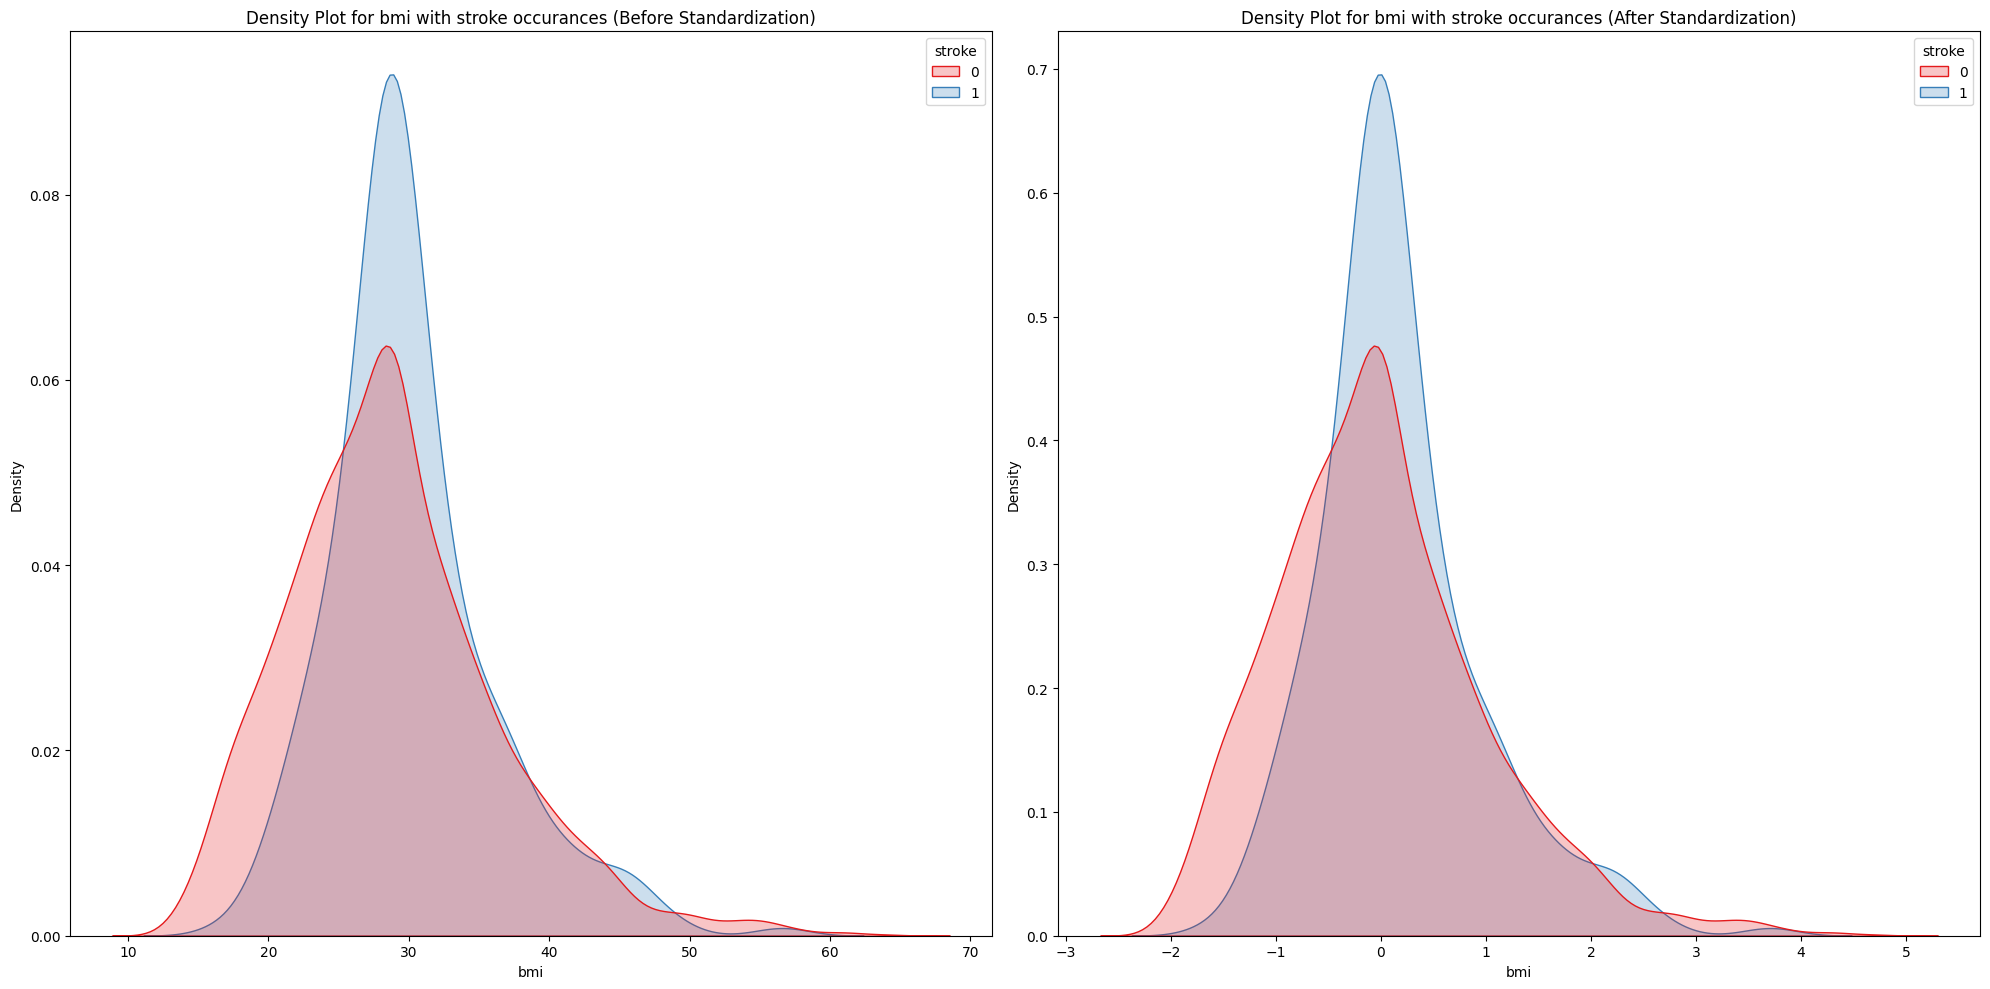

In [ ]:
# Density plot one feature for each 'stroke' category, before and after standardization

feature = 'bmi'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,10))

sns.kdeplot(data=data, x=feature, hue='stroke', fill=True, common_norm=False, palette="Set1", ax=axes[0])
axes[0].set_title(f'Density Plot for {feature} with stroke occurances (Before Standardization)')
axes[0].set_xlabel(f'{feature}')
axes[0].set_ylabel('Density')

sns.kdeplot(data=data_norm, x=feature, hue='stroke', fill=True, common_norm=False, palette="Set1", ax=axes[1])
axes[1].set_title(f'Density Plot for {feature} with stroke occurances (After Standardization)')
axes[1].set_xlabel(f'{feature}')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

#### Encoding Categorical Variable

In [ ]:
# Encode categorical features for future machine learning steps and prediction phase

# Define the mapping
# I set up the work_type from the lighter job to the hardest full-time one
# I set up the smoking_status from no smoking status to the increasing options until smokes option
work_type_mapping = {'Govt_job': 4, 'Never_worked': 1, 'Private': 3, 'Self-employed': 2, 'children': 0}
smoking_status = {'Unknown': 1, 'formerly smoked': 2, 'never smoked': 0, 'smokes': 3}

# Apply the mapping
data_norm['work_type'] = data_norm['work_type'].map(work_type_mapping)
data_norm['smoking_status'] = data_norm['smoking_status'].map(smoking_status)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Choose Categorical features
categorical_columns = data.select_dtypes(include='object').columns

# Dict to map the transformation
le_name_mapping = {}

# Encode categorical feature
for column in categorical_columns:

    data_norm[column] = label_encoder.fit_transform(data_norm[column])
    le_name_mapping[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

#data[categorical_columns]
data_norm[categorical_columns]


,gender,ever_married,work_type,Residence_type,smoking_status
0,1,1,0,1,0
1,0,1,0,0,0
2,1,1,0,0,0
3,0,1,0,1,0
4,0,1,0,0,0
...,...,...,...,...,...
5093,0,1,0,1,0
5094,0,1,0,1,0
5095,0,1,0,0,0
5096,1,1,0,0,0


In [ ]:
le_name_mapping

{'gender': {0: 0, 1: 1, 2: 2},
 'ever_married': {0: 0, 1: 1},
 'work_type': {nan: 0},
 'Residence_type': {0: 0, 1: 1},
 'smoking_status': {nan: 0}}

#### Feature Correlation

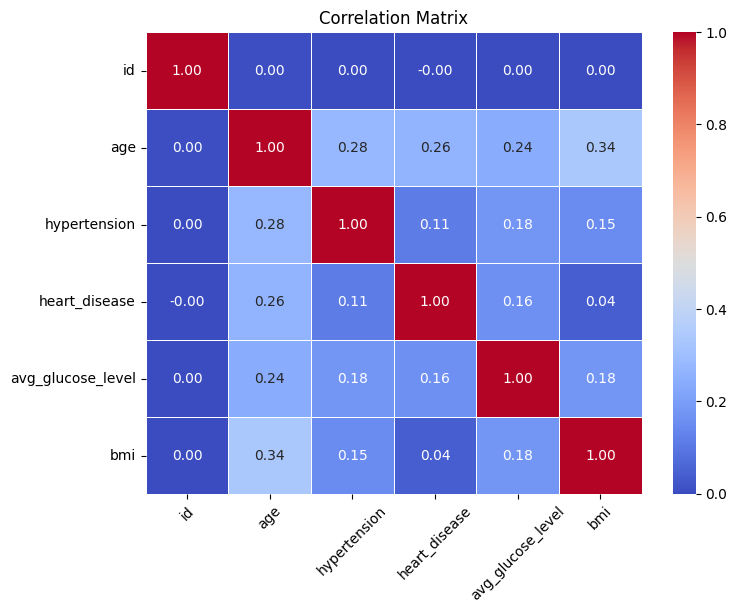

In [ ]:
# Observing Feature Correlation through the use of Heat Map

# Consider just numerical and discrete features, excluding
numerical_columns = data.drop('stroke', axis=1).select_dtypes(exclude='object').columns

corr_matrix = data[numerical_columns].corr()

fig = plt.figure(figsize=(8,6))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.xticks(rotation= 45)

plt.show()

## EDA

### Data Visualization

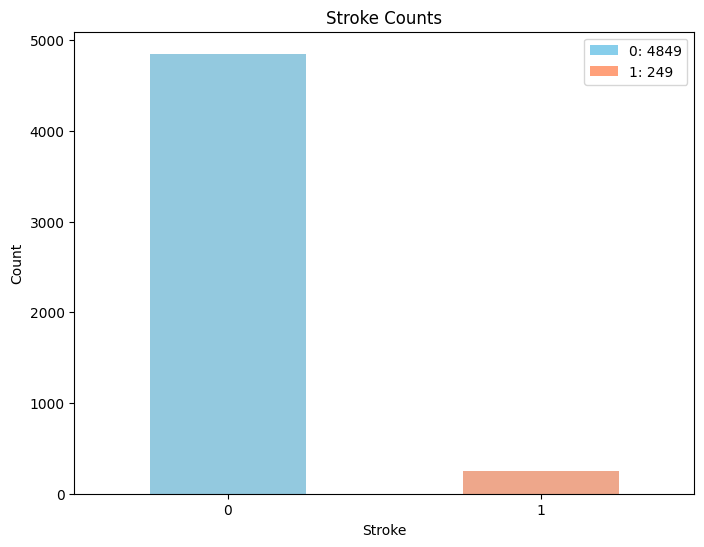

In [ ]:
# Histogram for stroke: it is clear we have an unbalanced dataset
# This is an issue we will discuss later

# Calculate counts for each option
counts = data['stroke'].value_counts()

# Define colors for each option
colors = {0: 'skyblue', 1: 'lightsalmon'}

fig = plt.figure(figsize=(8,6))
sns.countplot(data, x='stroke',hue='stroke', palette=colors.values(), width=0.5, legend=False)
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.title('Stroke Counts')

# Add Legend
for i, (count, color) in enumerate(zip(counts, colors.values())):
    plt.bar(i, 0, color=color, label=f'{i}: {count}')

plt.legend(loc='upper right')
plt.show()

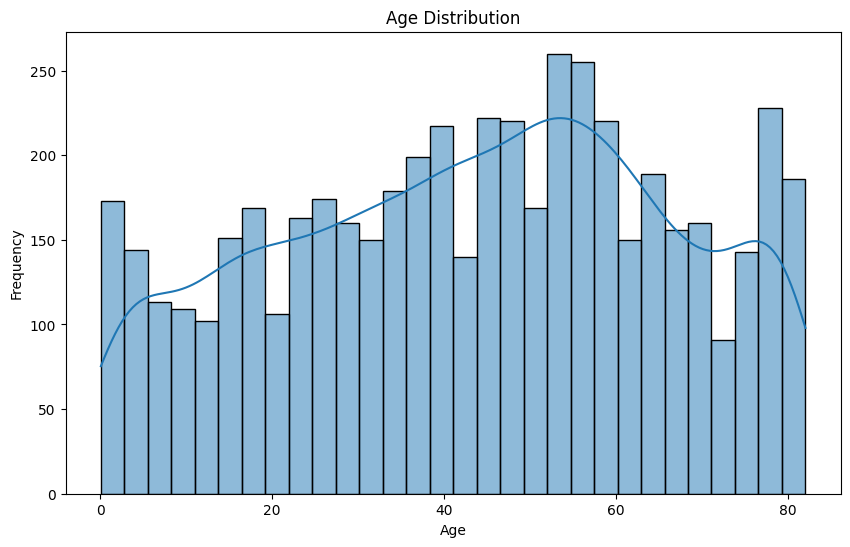

In [ ]:
# Distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(data['age'], kde=True, bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

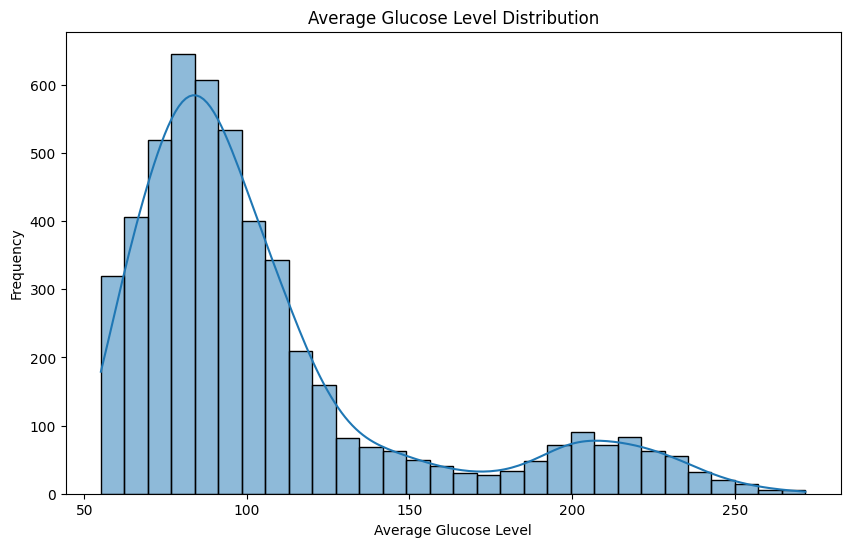

In [ ]:
# Distribution of average glucose level
plt.figure(figsize=(10, 6))
sns.histplot(data['avg_glucose_level'], kde=True, bins=30)
plt.title('Average Glucose Level Distribution')
plt.xlabel('Average Glucose Level')
plt.ylabel('Frequency')
plt.show()

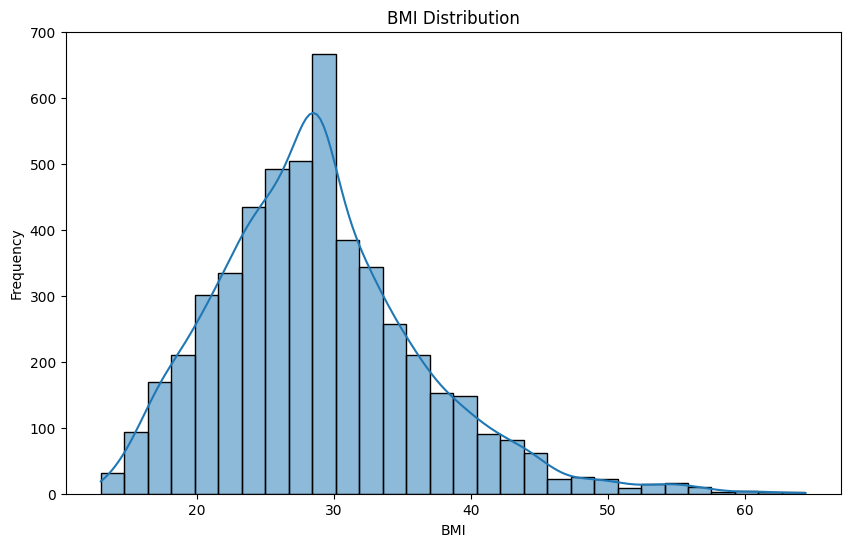

In [ ]:
# Distribution of BMI
plt.figure(figsize=(10, 6))
sns.histplot(data['bmi'], kde=True, bins=30)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

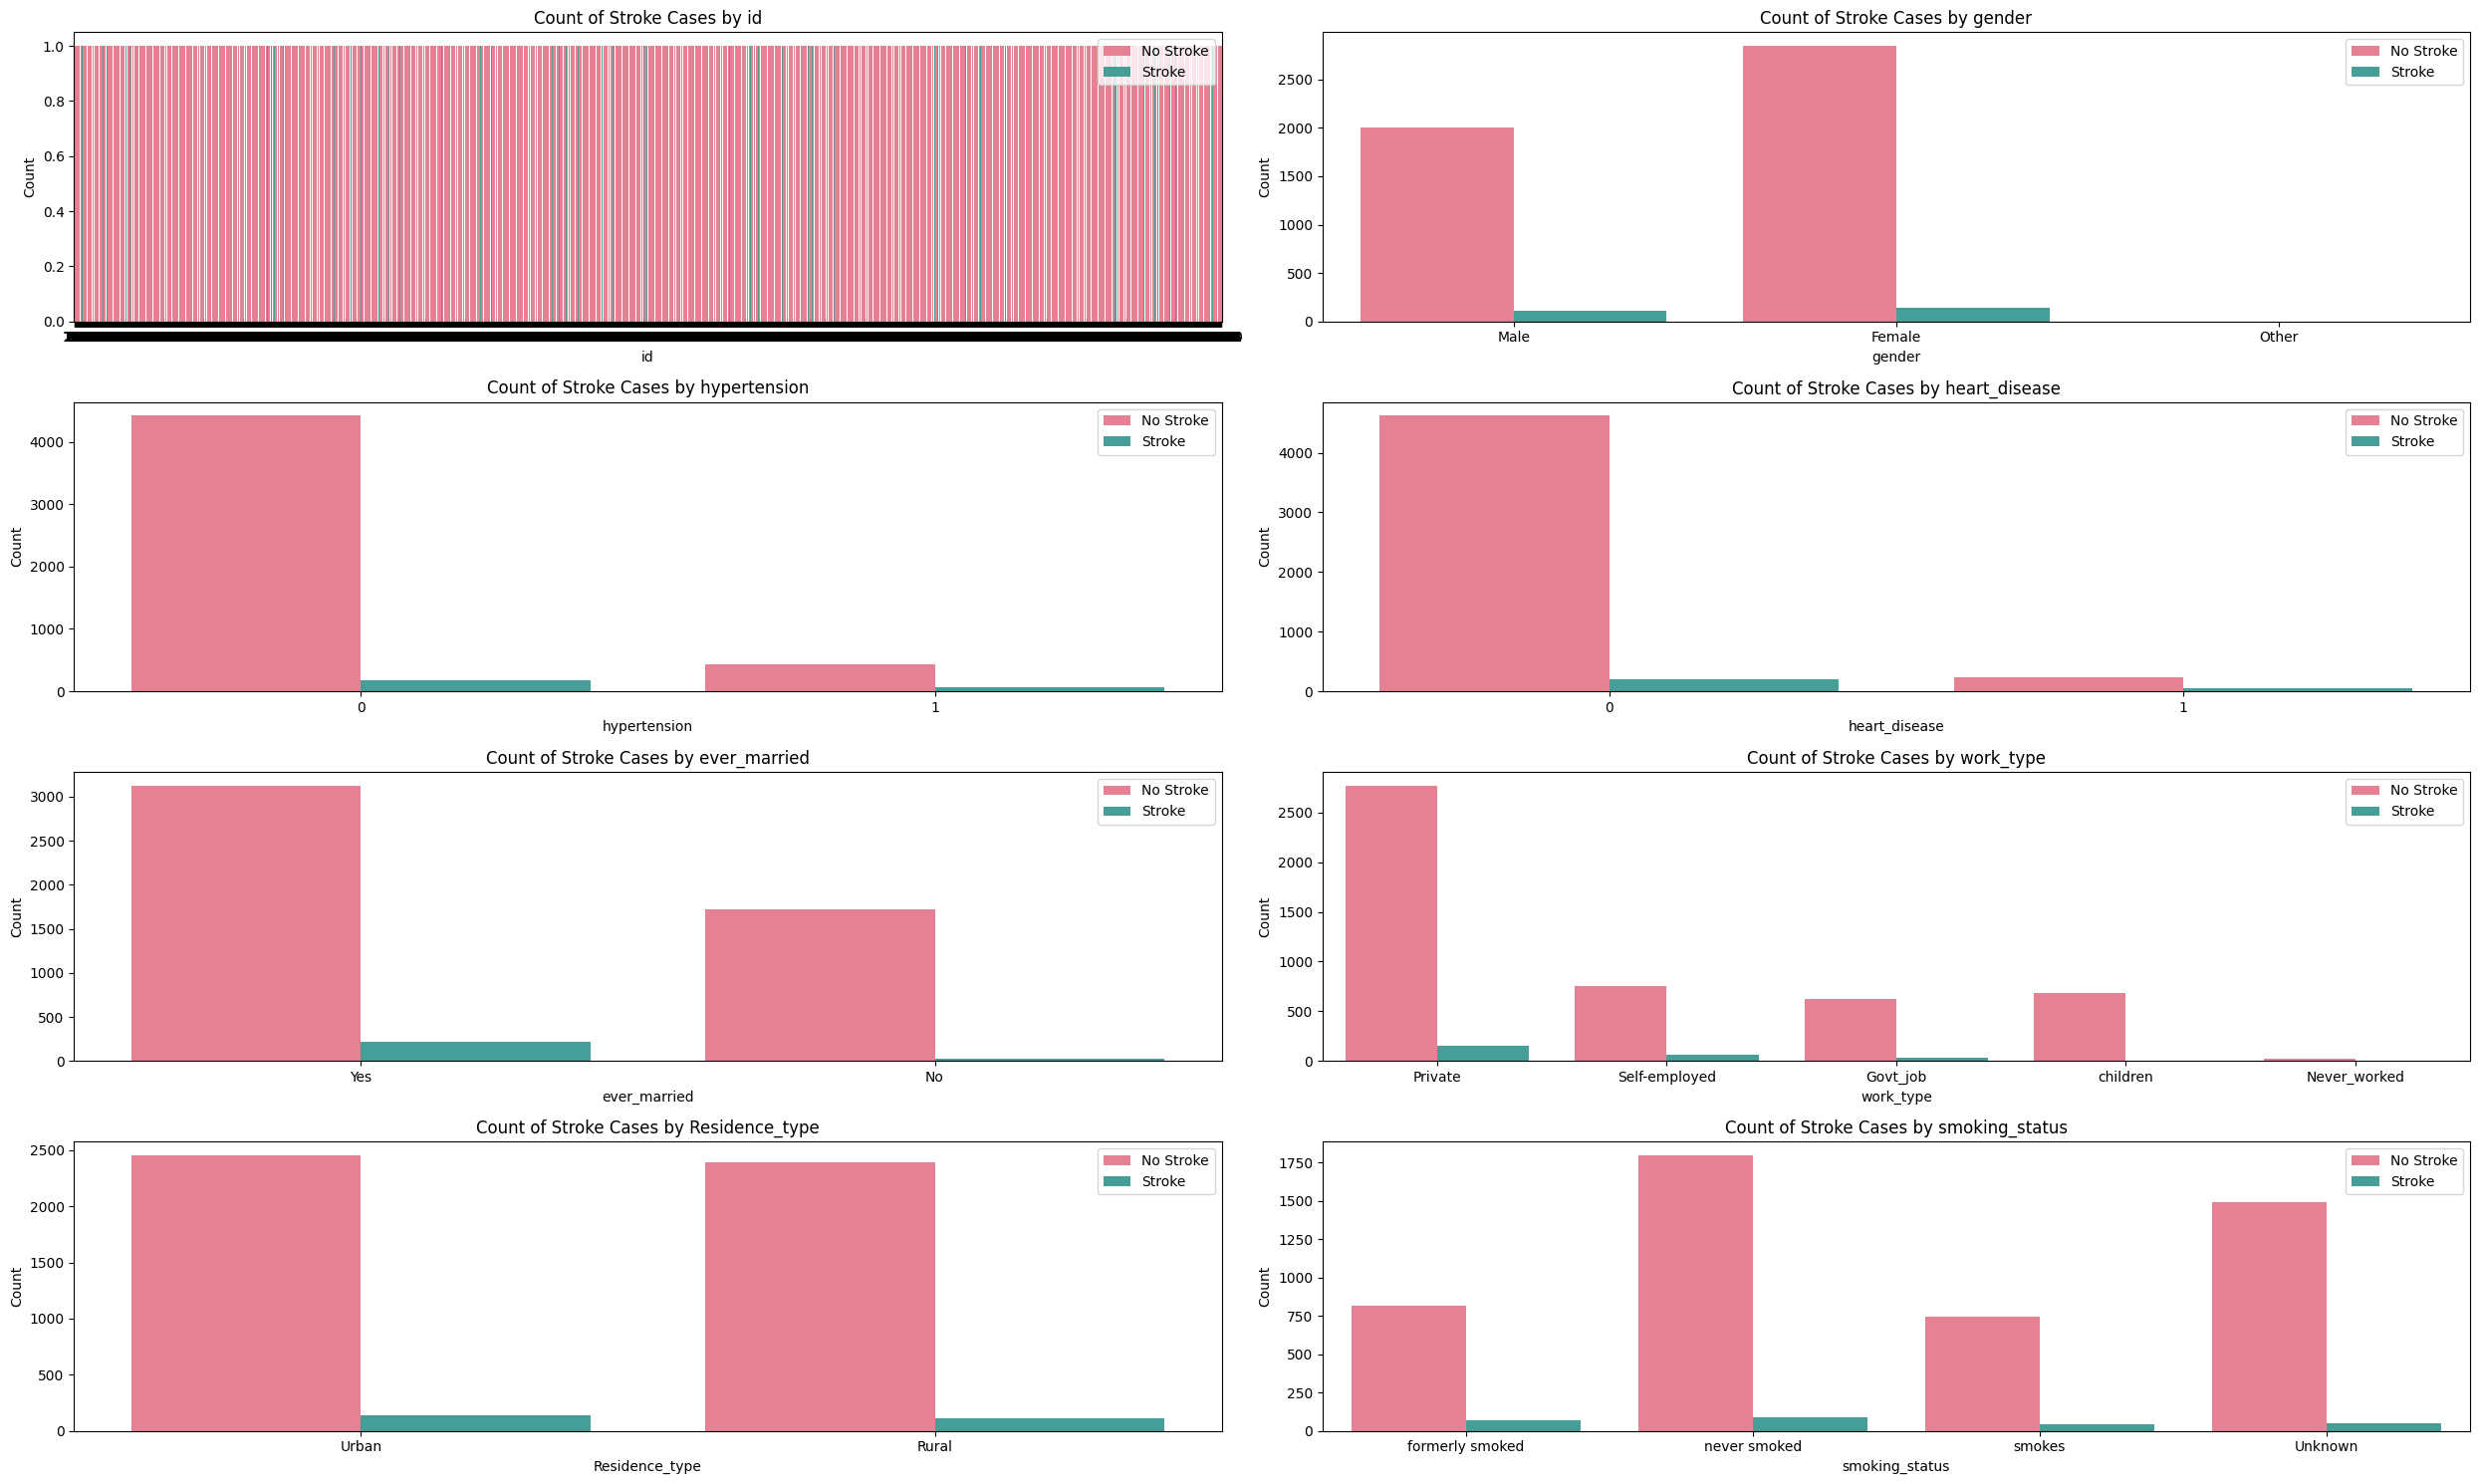

In [ ]:
# How categorical features are distributed according to stroke using Count Plots

# Define the categorical features you want to evaluate
categorical_features = data.drop("stroke", axis=1).select_dtypes(include=['object', 'int']).columns

# Calculate the number of rows and columns for subplots
num_cols = 2
num_rows = (len(categorical_features) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, 15))

axes = axes.flatten()

# Iterate over each categorical feature
for i, cat_feature in enumerate(categorical_features):
    # Create a countplot
    sns.countplot(data=data, x=cat_feature, hue='stroke', palette="husl", ax=axes[i])
    axes[i].set_title(f"Count of Stroke Cases by {cat_feature}")
    axes[i].set_xlabel(cat_feature)
    axes[i].set_ylabel("Count")
    axes[i].legend(labels=["No Stroke", "Stroke"])

# Hide any unused subplots
for j in range(len(categorical_features), num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Model Building

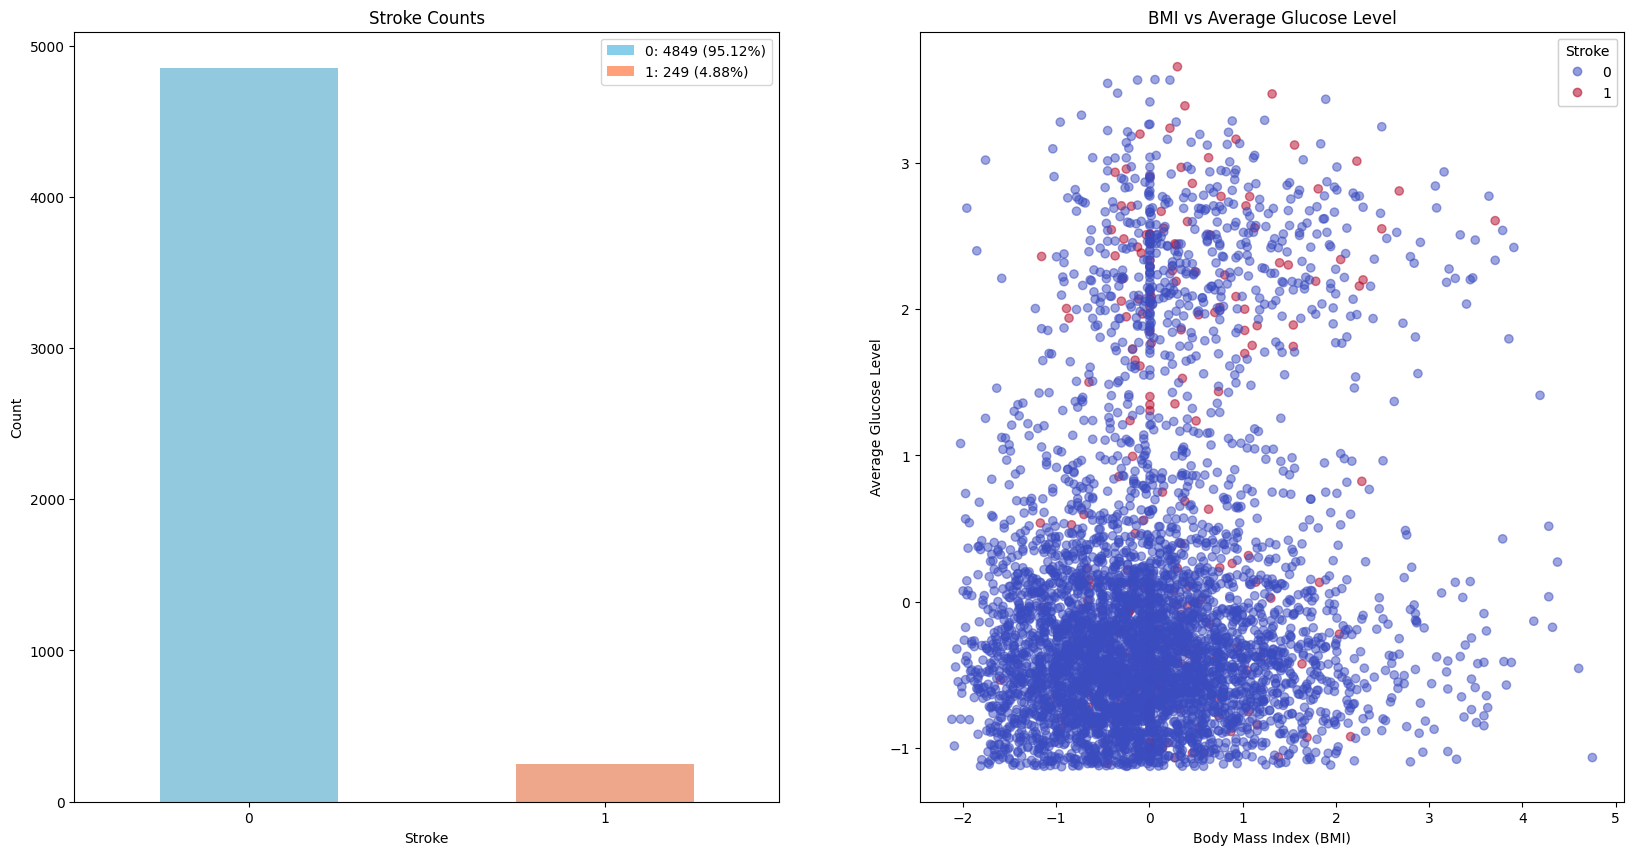

In [ ]:
# Count Plot for stroke
# Create a scatter plot with points colored according to the stroke feature

# Calculate counts for each option
counts = data_norm['stroke'].value_counts()

# Define colors for each option
colors = {0: 'skyblue', 1: 'lightsalmon'}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,10))

sns.countplot(data_norm, x='stroke',hue='stroke', palette=colors.values(), legend=False, width=0.5, ax=axes[0])
axes[0].set_xlabel('Stroke')
axes[0].set_ylabel('Count')
axes[0].set_title('Stroke Counts')

# Add Legend
for i, (count, color) in enumerate(zip(counts, colors.values())):
    axes[0].bar(i, 0, color=color, label=f'{i}: {count} ({(count/data_norm.shape[0]*100):.2f}%)')

axes[0].legend(loc='upper right')

scatter = axes[1].scatter(data_norm['bmi'], data_norm['avg_glucose_level'], c=data_norm['stroke'], cmap='coolwarm', alpha=0.5)

legend1 = axes[1].legend(*scatter.legend_elements(), title='Stroke')
axes[1].add_artist(legend1)

axes[1].set_title('BMI vs Average Glucose Level')
axes[1].set_xlabel('Body Mass Index (BMI)')
axes[1].set_ylabel('Average Glucose Level')

plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE

# Target is 'stroke' which has two values 0 and 1

X = data_norm.drop('stroke', axis=1)
y = data_norm['stroke']

print(f'Entire Dataset Shape:{X.shape}')
print(f'Entire Target Shape:{y.shape}')

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=59)
X_smote, y_smote = smote.fit_resample(X, y)

print(f'New Feature Shape:{X_smote.shape}')
print(f'New Target Shape:{y_smote.shape}')

Entire Dataset Shape:(5098, 11)
Entire Target Shape:(5098,)
New Feature Shape:(9698, 11)
New Target Shape:(9698,)


Text(0, 0.5, 'Average Glucose Level')

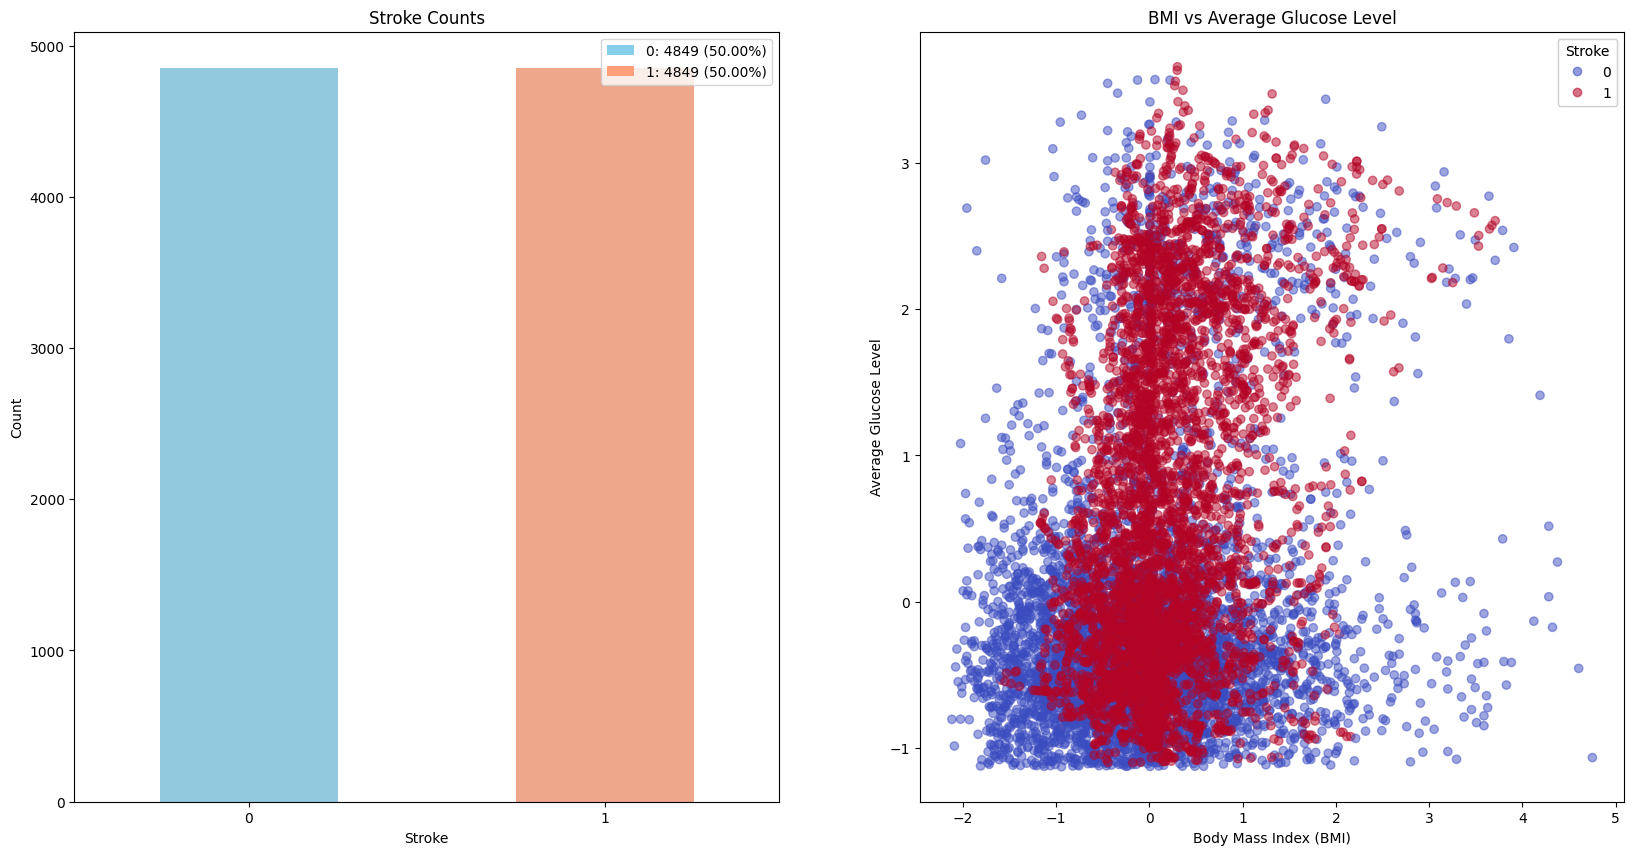

In [ ]:
# Unbalanced issue [SOLVED]

# Balanced df
df_balanced = pd.DataFrame()
df_balanced[X.columns] = X_smote
df_balanced['stroke'] = y_smote

# Calculate counts for each option
counts = df_balanced['stroke'].value_counts()

# Define colors for each option
colors = {0: 'skyblue', 1: 'lightsalmon'}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,10))


sns.countplot(df_balanced, x='stroke',hue='stroke', palette=colors.values(), legend=False, width=0.5, ax=axes[0])
axes[0].set_xlabel('Stroke')
axes[0].set_ylabel('Count')
axes[0].set_title('Stroke Counts')

# Add Legend
for i, (count, color) in enumerate(zip(counts, colors.values())):
    axes[0].bar(i, 0, color=color, label=f'{i}: {count} ({(count/df_balanced.shape[0]*100):.2f}%)')

axes[0].legend(loc='upper right')

scatter = axes[1].scatter(df_balanced['bmi'], df_balanced['avg_glucose_level'], c=df_balanced['stroke'], cmap='coolwarm', alpha=0.5)

legend1 = axes[1].legend(*scatter.legend_elements(), title='Stroke')
axes[1].add_artist(legend1)
axes[1].set_title('BMI vs Average Glucose Level')
axes[1].set_xlabel('Body Mass Index (BMI)')
axes[1].set_ylabel('Average Glucose Level')

#### Algorithms Selection

In [ ]:
# Define machine learning classifier with defauld parameters

models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('K-nearest neighbors', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB())
]

print(f'Evaluation using {len(models)} Machine Learning Classifiers')

Evaluation using 5 Machine Learning Classifiers


In [ ]:
# Perform iterated 10-fold stratified cross-validation for each model

# DF to save results
results_test_iter = pd.DataFrame()
results_train_iter = pd.DataFrame()
results_test = pd.DataFrame()
results_train = pd.DataFrame()

# DF to store confusion matrix and ROC results
test_confusion = pd.DataFrame()
train_confusion = pd.DataFrame()
roc = pd.DataFrame()

# Number of iterations
num_iter = 5

for name, model in models:

    print(f'Evaluating model: {name}...')

    # Define dict for each metric for both test and train predictions
    test_metrics = {
        'Accuracy' : [],
        'Precision' : [],
        'Recall' : [],
        'F1 Score' : [],
        'AUC' : []
    }

    train_metrics = {
        'Accuracy' : [],
        'Precision' : [],
        'Recall' : [],
        'F1 Score' : [],
        'AUC' : []
    }

    test_confusion_matrices = []
    train_confusion_matrices = []
    roc_auc_curves = []

    for i in range(0,num_iter):

        # Set up stratified CV
        stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state= i)

        for train_index, test_index in stratified_cv.split(X_smote, y_smote):

            X_train_fold, X_test_fold = X_smote.iloc[train_index], X_smote.iloc[test_index]
            y_train_fold, y_test_fold = y_smote.iloc[train_index], y_smote.iloc[test_index]

            model.fit(X_train_fold, y_train_fold)

            # predictions
            y_pred_fold = model.predict(X_test_fold)
            y_pred_train = model.predict(X_train_fold)

            # metrics calculation for test
            test_metrics['Accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
            test_metrics['Precision'].append(precision_score(y_test_fold, y_pred_fold))
            test_metrics['Recall'].append(recall_score(y_test_fold, y_pred_fold))
            test_metrics['F1 Score'].append(f1_score(y_test_fold, y_pred_fold))
            test_metrics['AUC'].append(roc_auc_score(y_test_fold, y_pred_fold))

            # metrics calculation for train
            train_metrics['Accuracy'].append(accuracy_score(y_train_fold, y_pred_train))
            train_metrics['Precision'].append(precision_score(y_train_fold, y_pred_train))
            train_metrics['Recall'].append(recall_score(y_train_fold, y_pred_train))
            train_metrics['F1 Score'].append(f1_score(y_train_fold, y_pred_train))
            train_metrics['AUC'].append(roc_auc_score(y_train_fold, y_pred_train))

            # Calculate confusion matrices
            test_confusion_matrices.append(confusion_matrix(y_test_fold, y_pred_fold))
            train_confusion_matrices.append(confusion_matrix(y_train_fold, y_pred_train))

            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_test_fold, model.predict_proba(X_test_fold)[:, 1])
            roc_auc_curves.append((fpr, tpr))

    # Collecting metric values for eahc iteration for each model (both train and test)
    metric_test_iter = {
        metric : value for metric, value in test_metrics.items()
    }
    cols_iter = pd.MultiIndex.from_product([[name], [str(j) for j in range(0,num_iter*10)]])
    results_test_iter_medium = pd.DataFrame(metric_test_iter.values(), columns=cols_iter)
    results_test_iter = pd.concat([results_test_iter, results_test_iter_medium], axis=1)

    metric_train_iter = {
        metric : value for metric, value in train_metrics.items()
    }
    results_train_iter_medium = pd.DataFrame(metric_train_iter.values(), columns=cols_iter)
    results_train_iter = pd.concat([results_train_iter, results_train_iter_medium], axis=1)

    # Collecting mean and std values for each metric and for each model (both train and test)
    mean_folds_metrics = {
        metric : (np.mean(value), np.std(value)) for metric, value in test_metrics.items()
    }

    cols = pd.MultiIndex.from_product([[name], ['Mean', 'Std']])

    res_test_medium = pd.DataFrame(mean_folds_metrics.values(), columns=cols)
    results_test = pd.concat([results_test, res_test_medium], axis=1)

    mean_train_metrics = {
        metric : (np.mean(value), np.std(value)) for metric, value in train_metrics.items()
    }

    res_train_medium = pd.DataFrame(mean_train_metrics.values(), columns=cols)
    results_train = pd.concat([results_train, res_train_medium], axis=1)

    # Save confusion matrices and ROC curves
    test_confusion[name] = test_confusion_matrices
    train_confusion[name] = train_confusion_matrices
    roc[name] = roc_auc_curves

# Use metrics names as rows index
results_test.index = mean_folds_metrics.keys()
results_train.index = mean_train_metrics.keys()
results_test_iter.index = metric_test_iter.keys()
results_train_iter.index = metric_train_iter.keys()

Evaluating model: Logistic Regression...
Evaluating model: Decision Tree...
Evaluating model: Random Forest...
Evaluating model: K-nearest neighbors...
Evaluating model: Naive Bayes...


In [ ]:
# Show test results for each classifier and each metric (mean and std)
results_test

Logistic Regression           Decision Tree           Random Forest  \
                         Mean       Std          Mean       Std          Mean   
Accuracy             0.527470  0.082522      0.885976  0.009837      0.924065   
Precision            0.524235  0.072991      0.872750  0.012431      0.898296   
Recall               0.984282  0.047231      0.903938  0.013914      0.956691   
F1 Score             0.678921  0.036910      0.887981  0.009713      0.926499   
AUC                  0.527461  0.082530      0.885976  0.009836      0.924066   

                    K-nearest neighbors           Naive Bayes            
                Std                Mean       Std        Mean       Std  
Accuracy   0.009537            0.643267  0.014829    0.789359  0.011034  
Precision  0.013893            0.638104  0.014617    0.719821  0.010926  
Recall     0.009912            0.662406  0.022226    0.947949  0.010160  
F1 Score   0.008960            0.649871  0.015671    0.818227  0.008671  
AUC        0.009539            0.643266  0.014831    0.789359  0.011043

### Results and Visualization

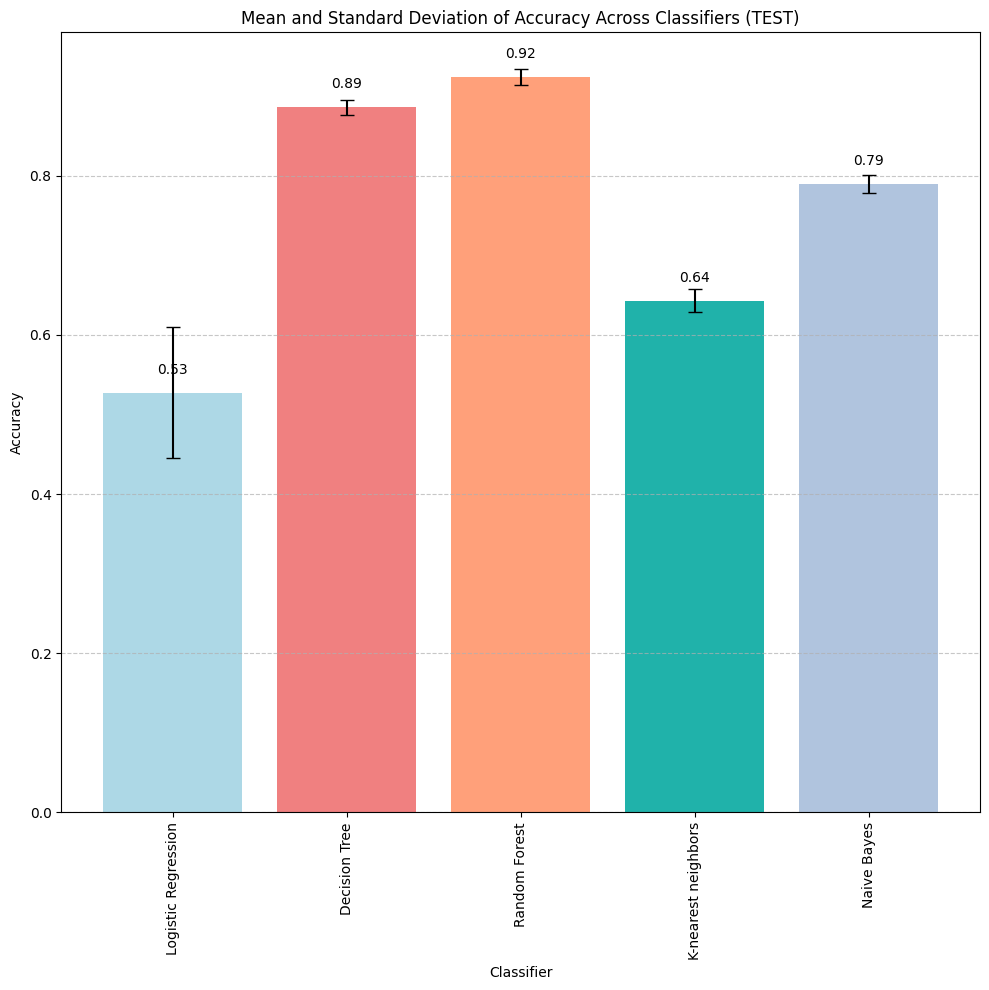

In [ ]:
#  Bar plot for each classifiers to visualize one of the evaluation metrics with mean and std values (using TEST results)

classifiers = ['Logistic Regression', 'Decision Tree', 'Random Forest',
              'K-nearest neighbors', 'Naive Bayes']

metric = 'Accuracy'

# Define colors for each bar
light_colors = ['lightblue', 'lightcoral' , 'lightsalmon', 'lightseagreen', 'lightsteelblue']

plt.figure(figsize=(10, 10))

bars = plt.bar(classifiers, results_test.loc[:, (slice(None), 'Mean')].loc[metric],
               yerr = results_test.loc[:, (slice(None), 'Std')].loc[metric],
                capsize=5, color=light_colors)

# Annotate each bar with its mean value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, round(height, 2),
             ha='center', va='bottom')

plt.xlabel('Classifier')
plt.ylabel(metric)
plt.title(f'Mean and Standard Deviation of {metric} Across Classifiers (TEST)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

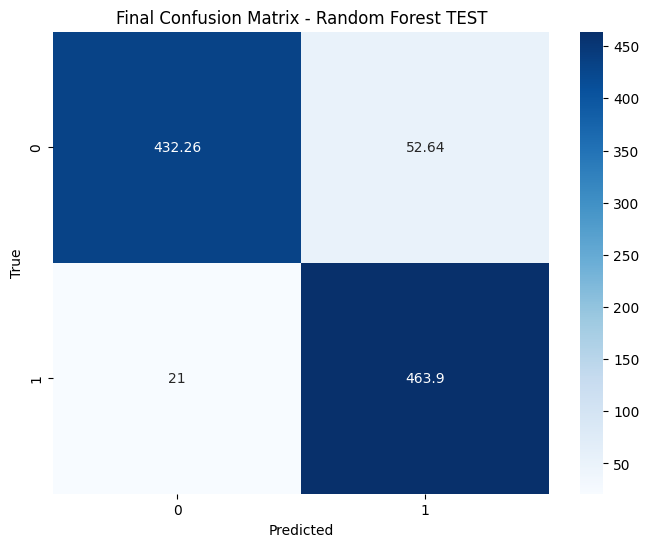

In [ ]:
# Display final confusion matrix for each model (using TEST results)

model_name = 'Random Forest'
confusion_matrix_mean = np.mean(test_confusion[model_name], axis=0)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion_matrix_mean, annot=True, cmap='Blues', fmt='g')

plt.title(f'Final Confusion Matrix - {model_name} TEST')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()